#transformers

In [1]:
! git clone https://gitlab.com/bigirqu/quranqa.git

Cloning into 'quranqa'...
remote: Enumerating objects: 333, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 333 (delta 43), reused 86 (delta 43), pack-reused 247
Receiving objects: 100% (333/333), 312.88 KiB | 11.17 MiB/s, done.
Resolving deltas: 100% (130/130), done.


**Install dependencies**

In [2]:
!pip install farasa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 26.7 MB/s eta 0:00:00


In [3]:
!pip install --upgrade pip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.1 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2


In [4]:
! pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.5/121.5 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 12.4 MB/s eta 0:00:00


**Import libraries**

In [5]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!ls /content/drive/MyDrive/data

QQA23_TaskB_qrcd_v1.2_dev.csv		    QQA23_TaskB_qrcd_v1.2_train.csv
QQA23_TaskB_qrcd_v1.2_dev.jsonl		    QQA23_TaskB_qrcd_v1.2_train.jsonl
QQA23_TaskB_qrcd_v1.2_test_gold.csv	    quranqa22_eval.cpython-310.pyc
QQA23_TaskB_qrcd_v1.2_test_gold.jsonl	    runs
QQA23_TaskB_qrcd_v1.2_test_noAnswers.jsonl


In [27]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import pandas as pd
import numpy as np
import json
import sys
from tqdm import tqdm
import time
sys.path.insert(0,"/content/drive/MyDrive/data/quranqa22_eval.cpython-310.pyc")
import quranqa22_eval as eval #/content/quranqa/code/quranqa22_eval.py

load data

In [8]:
train = pd.read_csv("/content/drive/MyDrive/data/QQA23_TaskB_qrcd_v1.2_train.csv")
validation = pd.read_csv("/content/drive/MyDrive/data/QQA23_TaskB_qrcd_v1.2_dev.csv")

In [26]:
train_dataset_jsonl = []
with open('/content/drive/MyDrive/Quran_QA/json_data/qrcd_v1.1_train.jsonl', 'r') as f:
    for line in f:
        train_dataset_jsonl.append(json.loads(line))

with open('/content/drive/MyDrive/Quran_QA/json_data/qrcd_v1.1_dev.jsonl', 'r') as f:
    for line in f:
        train_dataset_jsonl.append(json.loads(line))

In [10]:
len(train_dataset_jsonl)

1155

**Prepare data for prediction**

In [11]:
data = pd.concat([train, validation])

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1155 entries, 0 to 162
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   pq_id               1155 non-null   object
 1   passage             1155 non-null   object
 2   surah               1155 non-null   int64 
 3   verses              1155 non-null   object
 4   question            1155 non-null   object
 5   answer              1155 non-null   object
 6   start_char          1155 non-null   int64 
 7   processed passage   1155 non-null   object
 8   processed question  1155 non-null   object
 9   processed answer    1155 non-null   object
dtypes: int64(2), object(8)
memory usage: 99.3+ KB


In [13]:
data = data.filter(items=["pq_id","passage","question"])
data_unique_QA = data.drop_duplicates()

In [14]:
len(data_unique_QA)

1155

**models**

In [15]:
from transformers.utils.dummy_pt_objects import RemBertForSequenceClassification
def answer_question(row):
    pipe = pipeline("question-answering", model=model, tokenizer=tokenizer)
    result_row = pipe(question=row["question"], context=row["passage"], handle_impossible_answer=True, topk=5)
    return result_row

In [16]:
def Try_Transformer(tokenizer_name,model_name ):
  result = {}
  tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
  model = AutoModelForQuestionAnswering.from_pretrained(model_name)
  # Apply the function to the "question" and "passage" columns of the DataFrame
  for i in tqdm(range(len(data_unique_QA))):
    result_part = answer_question(data_unique_QA.iloc[i])
    result.update({data_unique_QA.iloc[i]["pq_id"]:result_part})
  return result

In [17]:
all_scores = {}

transformer

In [32]:
tokenizer = "CAMeL-Lab/bert-base-arabic-camelbert-mix"
model = "CAMeL-Lab/bert-base-arabic-camelbert-mix"
result = Try_Transformer(tokenizer, model)
scores = eval.evaluate(train_dataset_jsonl, result)
all_scores.update({tokenizer:scores})
print(scores)

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-mix and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/1155 [00:00<?, ?it/s]Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-mix and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 1/1155 [00:03<1:04:57,  3.38s/it]Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-mix and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for pred

{'pRR': 0.1410064332736399, 'exact_match': 0.003663003663003663, 'f1': 0.11400507702149036}


In [33]:
tokenizer = "CAMeL-Lab/bert-base-arabic-camelbert-ca"
model = "CAMeL-Lab/bert-base-arabic-camelbert-mix"
result = Try_Transformer(tokenizer, model)
scores = eval.evaluate(train_dataset_jsonl, result)
all_scores.update({tokenizer:scores})
print(scores)

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-mix and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/1155 [00:00<?, ?it/s]Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-mix and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 1/1155 [00:02<48:21,  2.51s/it]Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at CAMeL-Lab/bert-base-arabic-camelbert-mix and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predic

{'pRR': 0.14114263518763012, 'exact_match': 0.003663003663003663, 'f1': 0.11575394657900646}


In [34]:
tokenizer = "bert-base-cased"
model = "bert-base-cased"
result = Try_Transformer(tokenizer, model)
scores = eval.evaluate(train_dataset_jsonl, result)
all_scores.update({tokenizer:scores})
print(scores)

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/1155 [00:00<?, ?it/s]Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 1/1155 [00:01<37:07,  1.93s/it]Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 2/1155 [00:04<43:48,  2.28s/it]Some w

{'pRR': 0.10225475986315796, 'exact_match': 0.003663003663003663, 'f1': 0.0715484626328456}


In [35]:
tokenizer = "bert-base-uncased"
model = "bert-base-uncased"
result = Try_Transformer(tokenizer, model)
scores = eval.evaluate(train_dataset_jsonl, result)
all_scores.update({tokenizer:scores})
print(scores)

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/1155 [00:00<?, ?it/s]Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 1/1155 [00:02<40:54,  2.13s/it]Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 2/1155 [00:05<50:18,  2.62s/it]

{'pRR': 0.10752761255352813, 'exact_match': 0.002442002442002442, 'f1': 0.07745266510774369}


In [36]:
tokenizer = "aubmindlab/araelectra-base-generator"
model = "aubmindlab/araelectra-base-generator"
result = Try_Transformer(tokenizer, model)
scores = eval.evaluate(train_dataset_jsonl, result)
all_scores.update({tokenizer:scores})
print(scores)

Some weights of ElectraForQuestionAnswering were not initialized from the model checkpoint at aubmindlab/araelectra-base-generator and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/1155 [00:00<?, ?it/s]Some weights of ElectraForQuestionAnswering were not initialized from the model checkpoint at aubmindlab/araelectra-base-generator and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 1/1155 [00:01<22:42,  1.18s/it]Some weights of ElectraForQuestionAnswering were not initialized from the model checkpoint at aubmindlab/araelectra-base-generator and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictio

{'pRR': 0.1374346138467489, 'exact_match': 0.0, 'f1': 0.1081103623751302}


In [37]:
tokenizer = "aubmindlab/araelectra-base-discriminator"
model = "aubmindlab/araelectra-base-discriminator"
result = Try_Transformer(tokenizer, model)
scores = eval.evaluate(train_dataset_jsonl, result)
all_scores.update({tokenizer:scores})
print(scores)

Some weights of ElectraForQuestionAnswering were not initialized from the model checkpoint at aubmindlab/araelectra-base-discriminator and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/1155 [00:00<?, ?it/s]Some weights of ElectraForQuestionAnswering were not initialized from the model checkpoint at aubmindlab/araelectra-base-discriminator and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 1/1155 [00:02<52:09,  2.71s/it]Some weights of ElectraForQuestionAnswering were not initialized from the model checkpoint at aubmindlab/araelectra-base-discriminator and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it f

{'pRR': 0.1231051909582115, 'exact_match': 0.001221001221001221, 'f1': 0.09018172882558295}


new transformer

In [29]:
tokenizer = "IProject-10/bert-base-uncased-finetuned-squad2"
model = "IProject-10/bert-base-uncased-finetuned-squad2"
result = Try_Transformer(tokenizer, model)


100%|██████████| 1155/1155 [58:36<00:00,  3.04s/it]


In [30]:
scores = eval.evaluate(train_dataset_jsonl, result)
all_scores.update({tokenizer:scores})
print(scores)

{'pRR': 0.05694991640043145, 'exact_match': 0.001221001221001221, 'f1': 0.00681045635270636}


In [38]:
import json

# Specify the file name and path
filename = 'all_scores.json'

 # Write the scores dictionary to a JSON file
with open(filename, 'w') as json_file:
  json.dump(all_scores, json_file)

In [40]:
scores=pd.read_json("all_scores.json").T
scores.head(8)

,pRR,exact_match,f1
IProject-10/bert-base-uncased-finetuned-squad2,0.056950,0.001221,0.006810
CAMeL-Lab/bert-base-arabic-camelbert-mix,0.141006,0.003663,0.114005
CAMeL-Lab/bert-base-arabic-camelbert-ca,0.141143,0.003663,0.115754
bert-base-cased,0.102255,0.003663,0.071548
bert-base-uncased,0.107528,0.002442,0.077453
aubmindlab/araelectra-base-generator,0.137435,0.000000,0.108110
aubmindlab/araelectra-base-discriminator,0.123105,0.001221,0.090182


#scores

In [41]:
import pandas as pd
import matplotlib.pyplot as plt


scores=pd.read_json("all_scores.json").T


scores.head(8)

,pRR,exact_match,f1
IProject-10/bert-base-uncased-finetuned-squad2,0.056950,0.001221,0.006810
CAMeL-Lab/bert-base-arabic-camelbert-mix,0.141006,0.003663,0.114005
CAMeL-Lab/bert-base-arabic-camelbert-ca,0.141143,0.003663,0.115754
bert-base-cased,0.102255,0.003663,0.071548
bert-base-uncased,0.107528,0.002442,0.077453
aubmindlab/araelectra-base-generator,0.137435,0.000000,0.108110
aubmindlab/araelectra-base-discriminator,0.123105,0.001221,0.090182


In [42]:
scores=scores.reset_index()
scores=scores.rename(columns={'index': 'model'})
scores.head(8)

,model,pRR,exact_match,f1
0,IProject-10/bert-base-uncased-finetuned-squad2,0.056950,0.001221,0.006810
1,CAMeL-Lab/bert-base-arabic-camelbert-mix,0.141006,0.003663,0.114005
2,CAMeL-Lab/bert-base-arabic-camelbert-ca,0.141143,0.003663,0.115754
3,bert-base-cased,0.102255,0.003663,0.071548
4,bert-base-uncased,0.107528,0.002442,0.077453
5,aubmindlab/araelectra-base-generator,0.137435,0.000000,0.108110
6,aubmindlab/araelectra-base-discriminator,0.123105,0.001221,0.090182


In [43]:
scores['model'].values

array(['IProject-10/bert-base-uncased-finetuned-squad2',
       'CAMeL-Lab/bert-base-arabic-camelbert-mix',
       'CAMeL-Lab/bert-base-arabic-camelbert-ca', 'bert-base-cased',
       'bert-base-uncased', 'aubmindlab/araelectra-base-generator',
       'aubmindlab/araelectra-base-discriminator'], dtype=object)

In [44]:
scores.columns

Index(['model', 'pRR', 'exact_match', 'f1'], dtype='object')

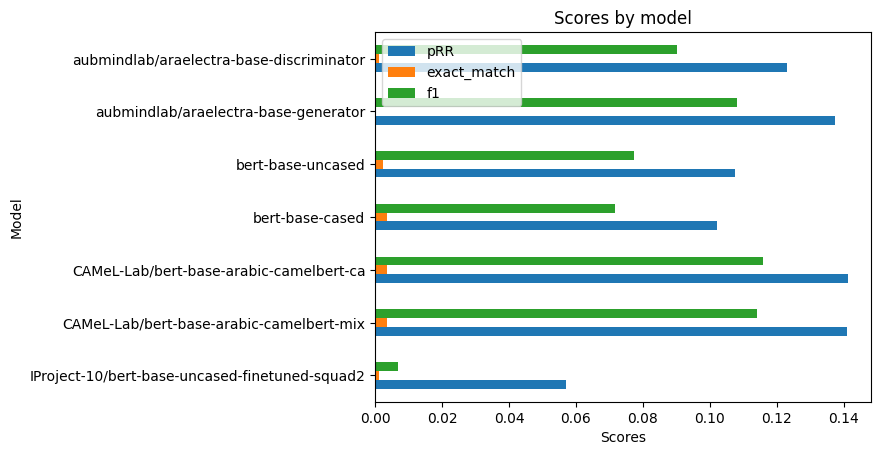

In [45]:
scores.plot.barh(x='model', y=[ 'pRR', 'exact_match', 'f1'], rot=0)

# Set the plot title and axis labels
plt.title('Scores by model')
plt.xlabel('Scores')
plt.ylabel('Model')
plt.legend(loc="upper left", frameon= True)

# Display the plot
plt.show()